Possible reasonfor low accuracy: Uncertain training labels

In [1]:
#Importálom a korábbi notebookoban készített modell -t és baseline -t és Dataset -et
import sys
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('/app/src/lib')) #import Dataloader
sys.path.append(os.path.abspath('/app/src')) #for config
import config
config.HEADLESS_PLOT = False

## Metric eval definitions

In [2]:
import torch
import torchmetrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import config
from utils import create_deterministic_splitted_datasets
from lib.dataloader import FlagDataset
from lib.model import FlagClassifier
from lib.baseline_model import BaselineClassifier
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix


import utils

def evaluate_model(model, classes, train_ds, val_ds, test_ds, batch_size=64, device=None):
    """
    Evaluates a PyTorch model on Train, Val, and Test datasets.
    Prints full text reports (Global, Confusion Matrix, Per-Class) and plots the results.
    """
    
    # --- 1. SETUP & VALIDATION ---
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        if device == "cpu" and torch.backends.mps.is_available():
            device = "mps"
    
    print(f"Using device: {device}")
    model = model.to(device)
    model.eval()

    datasets = {"Train": train_ds, "Val": val_ds, "Test": test_ds}
    num_classes = len(classes)
    
    # Validate Datasets
    for name, ds in datasets.items():
        if not isinstance(ds, Dataset):
             if not (hasattr(ds, '__len__') and hasattr(ds, '__getitem__')):
                raise TypeError(f"Error: {name}_ds is not a valid PyTorch Dataset.")
        if len(ds) == 0:
            raise ValueError(f"Error: {name}_ds is empty.")
        try:
            # Smoke test
            _ = ds[0] 
        except Exception as e:
            raise RuntimeError(f"Failed to fetch item from {name}_ds. Error: {e}")

    # --- 2. INITIALIZE METRICS ---
    # added Top-3 Accuracy here
    metrics = torchmetrics.MetricCollection({
        'Global Acc': torchmetrics.Accuracy(task="multiclass", num_classes=num_classes),
        'Top-2 Acc':  torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=2),
        'Top-3 Acc':  torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=3),
        'Precision':  torchmetrics.Precision(task="multiclass", num_classes=num_classes, average=None),
        'Recall':     torchmetrics.Recall(task="multiclass", num_classes=num_classes, average=None),
        'ConfMat':    torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes)
    }).to(device)

    results_list = []

    # --- 3. EVALUATION LOOP ---
    with torch.no_grad():
        for phase, ds in datasets.items():
            print(f"\n{'='*20} {phase.upper()} DATASET {'='*20}")
            
            loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
            
            # Inference Loop
            for inputs, targets in loader:
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
                metrics.update(logits, targets)
            
            # Compute final results for this dataset
            res = metrics.compute()
            
            # --- A. PRINT GLOBAL METRICS ---
            print(f"\n[Global Metrics]")
            print(f"Accuracy:      {res['Global Acc'].item():.4f}")
            print(f"Top-2 Acc:     {res['Top-2 Acc'].item():.4f}")
            print(f"Top-3 Acc:     {res['Top-3 Acc'].item():.4f}")

            # --- B. PRINT CONFUSION MATRIX ---
            cm = res['ConfMat'].cpu()
            #print(f"\n[Confusion Matrix] (Rows=True, Cols=Pred)")
            # Create a Pandas DataFrame for a prettier print
            #cm_df = pd.DataFrame(cm.numpy(), index=classes, columns=classes)
            #print(cm_df)

            # --- C. CALCULATE & PRINT PER-CLASS METRICS ---
            total_samples = cm.sum()
            per_class_acc = []
            
            prec_vals = res['Precision'].cpu().tolist()
            rec_vals = res['Recall'].cpu().tolist()

            print(f"\n[Per-Class Metrics]")
            print(f"{'Class Name':<15} | {'Precision':<10} | {'Recall':<10} | {'OvR Acc':<10}")
            print("-" * 55)

            for i, class_name in enumerate(classes):
                # Custom Calculation: One-vs-Rest Accuracy
                tp = cm[i, i]
                fn = cm[i, :].sum() - tp
                fp = cm[:, i].sum() - tp
                tn = total_samples - (tp + fp + fn)
                acc_ovr = (tp + tn) / total_samples
                per_class_acc.append(acc_ovr.item())
                
                # Print Row
                print(f"{class_name:<15} | {prec_vals[i]:.4f}     | {rec_vals[i]:.4f}     | {acc_ovr:.4f}")

                # Store for plotting
                results_list.append({"Dataset": phase, "Class": class_name, "Metric": "Precision", "Score": prec_vals[i]})
                results_list.append({"Dataset": phase, "Class": class_name, "Metric": "Recall", "Score": rec_vals[i]})
                results_list.append({"Dataset": phase, "Class": class_name, "Metric": "OvR Accuracy", "Score": acc_ovr.item()})

            # Reset for next dataset
            metrics.reset()

    # --- 4. PLOTTING ---
    df = pd.DataFrame(results_list)
    
    sns.set_theme(style="whitegrid")
    g = sns.catplot(
        data=df, x="Class", y="Score", hue="Metric", col="Dataset", 
        kind="bar", palette="viridis", height=5, aspect=1.2, sharey=True
    )
    g.set_axis_labels("", "Score (0-1)")
    g.set(ylim=(0, 1.05))
    g.fig.suptitle('Evaluation Metrics by Class and Dataset', fontsize=16, y=1.05)
    
    # Rotate labels
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)

    plt.show()
    
    return df

## Running eval

In [3]:
import config
from utils import create_deterministic_splitted_datasets
from lib.dataloader import FlagDataset
from lib.model import FlagClassifier
from lib.baseline_model import BaselineClassifier

CLASS_LABELS = ['Bearish Normal', 'Bearish Pennant', 'Bearish Wedge', 'Bullish Normal', 'Bullish Pennant', 'Bullish Wedge']

CSV_FILE = config.CSV_FILE
FLAG_TARGET_LENGTH = config.FLAG_TARGET_LENGTH

MODEL_LOAD_PATH = '/app/output/submission/best_model_FlagClassifier.pth'
BASELINE_LOAD_PATH = '/app/output/submission/best_model_baseline.pth'

full_dataset = FlagDataset(csv_file=CSV_FILE, target_length=FLAG_TARGET_LENGTH, return_idx = False)
train_ds, val_ds, test_ds = create_deterministic_splitted_datasets(full_dataset)

# Loading models
model = FlagClassifier(num_classes=len(full_dataset.classes))
model.load_state_dict(torch.load(MODEL_LOAD_PATH, map_location=config.DEVICE))

baseline = BaselineClassifier(num_classes=len(full_dataset.classes))
baseline.load_state_dict(torch.load(BASELINE_LOAD_PATH, map_location=config.DEVICE))

<All keys matched successfully>

Using device: cuda

==================== TRAIN DATASET ====================

[Global Metrics]
Accuracy:      0.3481
Top-2 Acc:     0.5967
Top-3 Acc:     0.7956

[Per-Class Metrics]
Class Name      | Precision  | Recall     | OvR Acc   
-------------------------------------------------------
Bearish Normal  | 0.3504     | 0.8542     | 0.5414
Bearish Pennant | 0.0000     | 0.0000     | 0.9088
Bearish Wedge   | 0.2500     | 0.0408     | 0.8536
Bullish Normal  | 0.4070     | 0.3723     | 0.6961
Bullish Pennant | 0.0000     | 0.0000     | 0.8978
Bullish Wedge   | 0.2059     | 0.1321     | 0.7983

==================== VAL DATASET ====================

[Global Metrics]
Accuracy:      0.3981
Top-2 Acc:     0.6893
Top-3 Acc:     0.8155

[Per-Class Metrics]
Class Name      | Precision  | Recall     | OvR Acc   
-------------------------------------------------------
Bearish Normal  | 0.3824     | 0.8667     | 0.5534
Bearish Pennant | 1.0000     | 0.1250     | 0.9320
Bearish Wedge   | 1.0000     

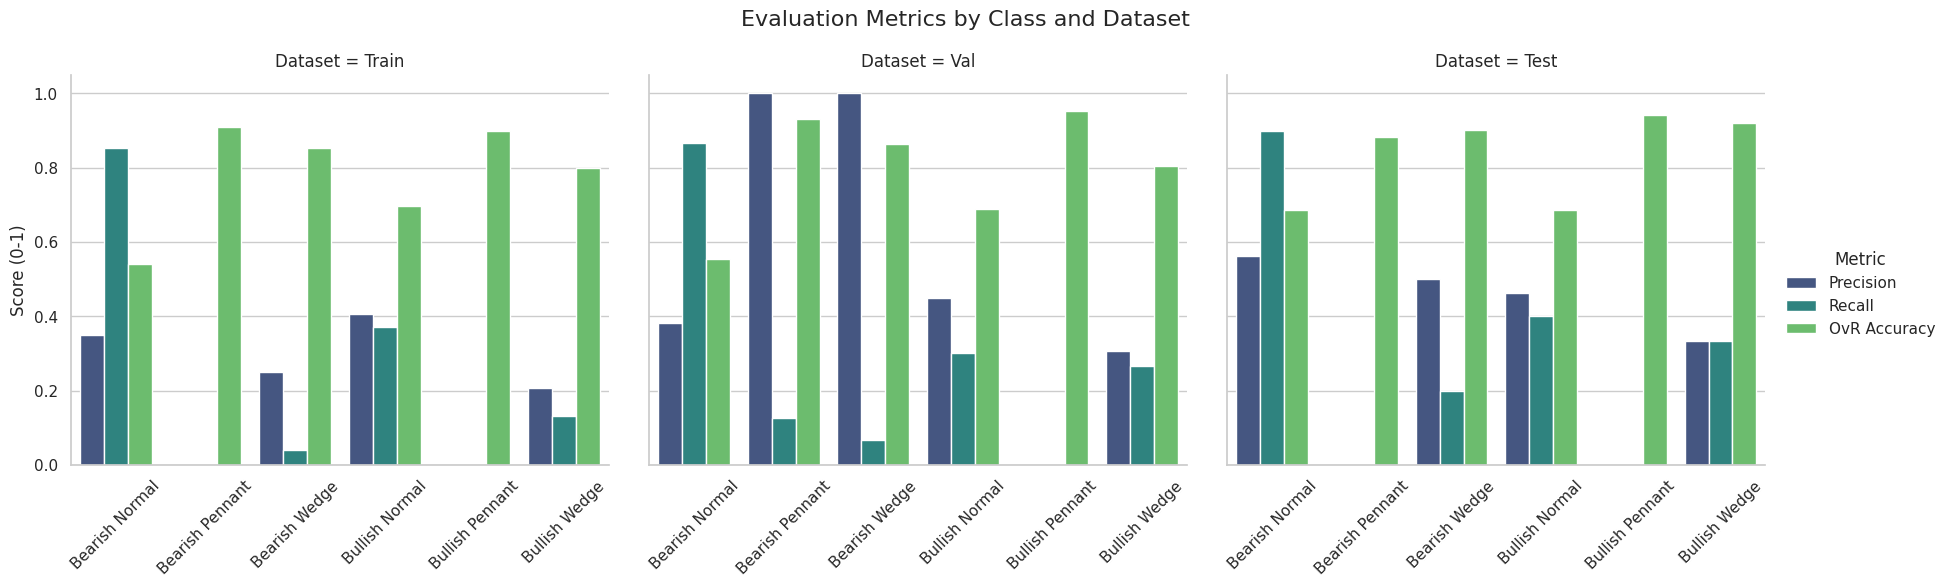

Using device: cuda

==================== TRAIN DATASET ====================

[Global Metrics]
Accuracy:      0.2459
Top-2 Acc:     0.5028
Top-3 Acc:     0.7210

[Per-Class Metrics]
Class Name      | Precision  | Recall     | OvR Acc   
-------------------------------------------------------
Bearish Normal  | 0.2530     | 0.8854     | 0.2762
Bearish Pennant | 0.2000     | 0.0303     | 0.9006
Bearish Wedge   | 0.1429     | 0.0612     | 0.8232
Bullish Normal  | 0.0000     | 0.0000     | 0.7403
Bullish Pennant | 0.0000     | 0.0000     | 0.8978
Bullish Wedge   | 0.0000     | 0.0000     | 0.8536

==================== VAL DATASET ====================

[Global Metrics]
Accuracy:      0.3010
Top-2 Acc:     0.6311
Top-3 Acc:     0.8058

[Per-Class Metrics]
Class Name      | Precision  | Recall     | OvR Acc   
-------------------------------------------------------
Bearish Normal  | 0.2959     | 0.9667     | 0.3204
Bearish Pennant | 0.0000     | 0.0000     | 0.9223
Bearish Wedge   | 0.4000     

/usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


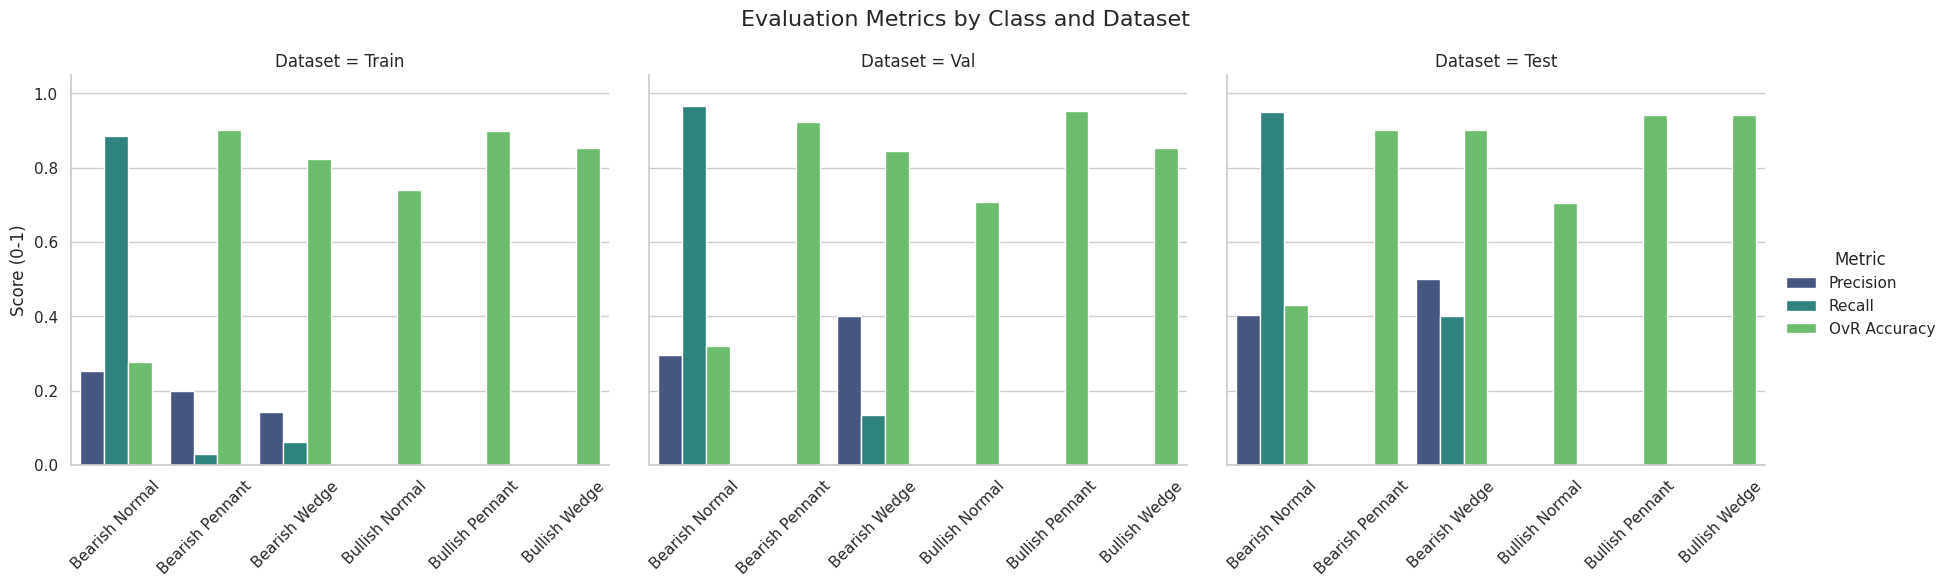

In [4]:
# Run evaluation for model
model_df = evaluate_model(
    model=model,
    classes=CLASS_LABELS,
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    batch_size=config.BATCH_SIZE,   # Adjust based on your GPU memory
    device=config.DEVICE    # Optional, it will auto-detect if left None
)

# Run evaluation for baseline
baseline_df = evaluate_model(
    model=baseline,
    classes=CLASS_LABELS,
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    batch_size=config.BATCH_SIZE,   # Adjust based on your GPU memory
    device=config.DEVICE    # Optional, it will auto-detect if left None
)

## Bearish vs Bullish eval

In [5]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix

def evaluate_directional_accuracy(model, train_ds, val_ds, test_ds, batch_size=64, device=None):
    """
    Evaluates Directional Accuracy.
    Group 0 (Bearish): ['Bearish Normal', 'Bearish Pennant', 'Bearish Wedge'] (Indices 0-2)
    Group 1 (Bullish): ['Bullish Normal', 'Bullish Pennant', 'Bullish Wedge'] (Indices 3-5)
    """
    # 1. SETUP
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        if device == "cpu" and torch.backends.mps.is_available():
            device = "mps"
            
    print(f"Using device: {device}")
    model = model.to(device)
    model.eval()
    
    datasets = {"Train": train_ds, "Val": val_ds, "Test": test_ds}
    
    # Metrics (Binary because we are grouping into 2 sets)
    acc_metric = BinaryAccuracy().to(device)
    conf_mat = BinaryConfusionMatrix().to(device)
    
    results_list = []

    print(f"\n{'='*20} DIRECTIONAL EVALUATION {'='*20}")
    print("Mapping: [0,1,2] -> Bearish (Down) | [3,4,5] -> Bullish (Up)")

    with torch.no_grad():
        for phase, ds in datasets.items():
            loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
            
            all_preds_bin = []
            all_targets_bin = []
            
            for inputs, targets in loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward Pass
                logits = model(inputs)
                preds = torch.argmax(logits, dim=1)
                
                # --- MAPPING LOGIC ---
                # Indices 0, 1, 2 are < 3 (Bearish Group -> 0)
                # Indices 3, 4, 5 are >= 3 (Bullish Group -> 1)
                preds_bin = (preds >= 3).long()
                targets_bin = (targets >= 3).long()
                
                all_preds_bin.append(preds_bin)
                all_targets_bin.append(targets_bin)
            
            # Combine all batches
            preds_full = torch.cat(all_preds_bin)
            targets_full = torch.cat(all_targets_bin)
            
            # Compute Metrics
            acc = acc_metric(preds_full, targets_full)
            cm = conf_mat(preds_full, targets_full).cpu().numpy()
            
            # Extract CM stats
            # [0,0]=TN (True Bearish), [0,1]=FP (False Bullish)
            # [1,0]=FN (False Bearish), [1,1]=TP (True Bullish)
            tn, fp = cm[0] 
            fn, tp = cm[1] 
            total = cm.sum()
            
            # Key Ratios
            accuracy = (tn + tp) / total
            critical_error_rate = fp / total  # Predicted Bullish, actually Bearish (Loss)
            missed_opp_rate = fn / total      # Predicted Bearish, actually Bullish (FOMO)
            
            # Print Text Report
            print(f"\n--- {phase} DATASET ---")
            print(f"Directional Acc: {accuracy:.2%}")
            print(f"Critical Error:  {critical_error_rate:.2%} (Pred Bullish but was Bearish)")
            
            # Store for Plotting
            results_list.append({"Dataset": phase, "Metric": "Directional Acc", "Score": accuracy})
            results_list.append({"Dataset": phase, "Metric": "Critical Error (Risk)", "Score": critical_error_rate})
            results_list.append({"Dataset": phase, "Metric": "Missed Opp (FOMO)", "Score": missed_opp_rate})

            # Reset metrics for next loop
            acc_metric.reset()
            conf_mat.reset()

    # 2. PLOTTING
    df = pd.DataFrame(results_list)
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Create grouped bar chart
    ax = sns.barplot(
        data=df, 
        x="Dataset", 
        y="Score", 
        hue="Metric", 
        palette=["#2ecc71", "#e74c3c", "#f1c40f"] # Green, Red, Yellow
    )
    
    # Formatting
    ax.set_title("Bullish/Bearish Directional Performance", fontsize=16)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Percentage (0-1)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add values on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

    plt.tight_layout()
    plt.show()
    
    return df

Using device: cuda

==================== DIRECTIONAL EVALUATION ====================
Mapping: [0,1,2] -> Bearish (Down) | [3,4,5] -> Bullish (Up)

--- Train DATASET ---
Directional Acc: 68.51%
Critical Error:  6.91% (Pred Bullish but was Bearish)

--- Val DATASET ---
Directional Acc: 71.84%
Critical Error:  5.83% (Pred Bullish but was Bearish)

--- Test DATASET ---
Directional Acc: 78.43%
Critical Error:  5.88% (Pred Bullish but was Bearish)


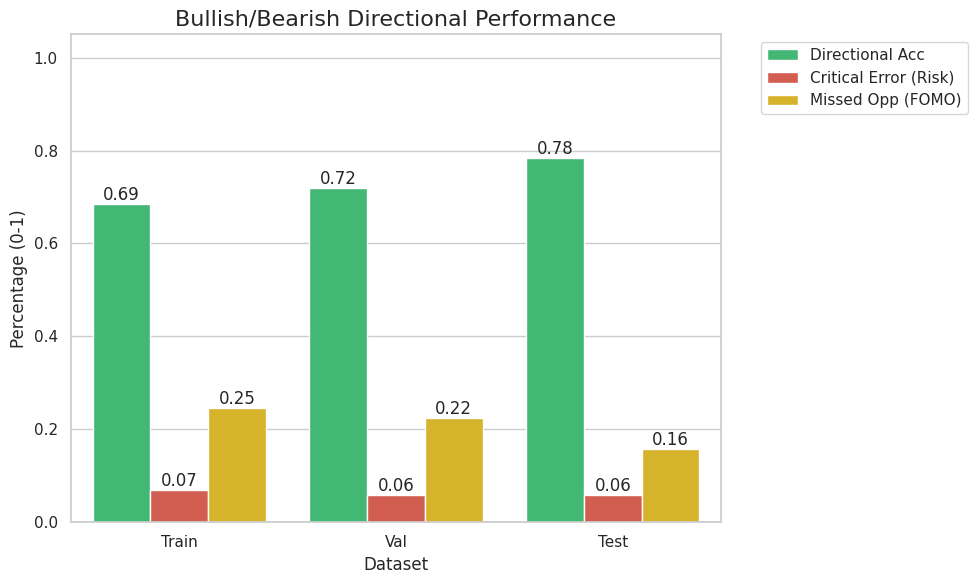




BASELINE EVAL



Using device: cuda

==================== DIRECTIONAL EVALUATION ====================
Mapping: [0,1,2] -> Bearish (Down) | [3,4,5] -> Bullish (Up)

--- Train DATASET ---
Directional Acc: 49.17%
Critical Error:  0.00% (Pred Bullish but was Bearish)

--- Val DATASET ---
Directional Acc: 51.46%
Critical Error:  0.00% (Pred Bullish but was Bearish)

--- Test DATASET ---
Directional Acc: 58.82%
Critical Error:  0.00% (Pred Bullish but was Bearish)


/usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


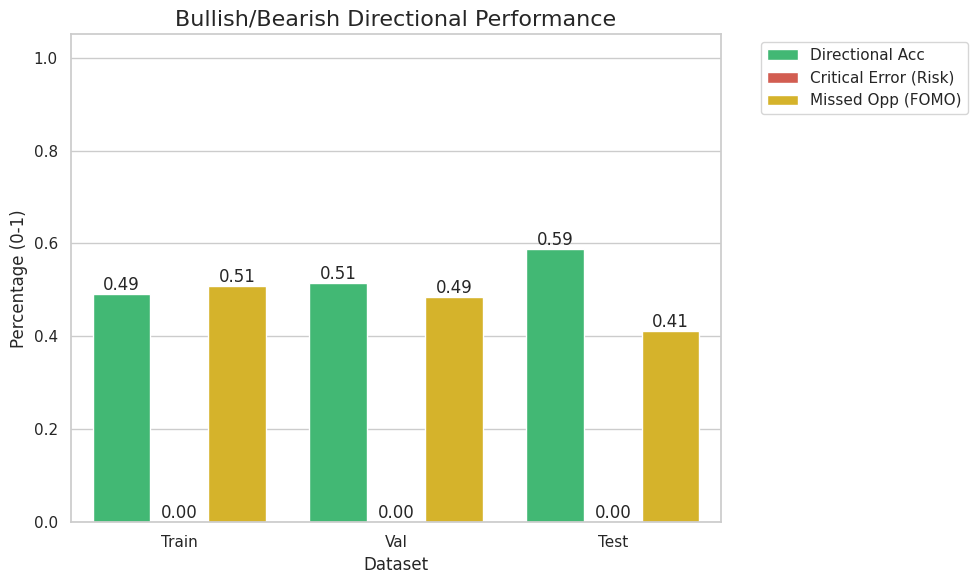

,Dataset,Metric,Score
0,Train,Directional Acc,0.491713
1,Train,Critical Error (Risk),0.000000
2,Train,Missed Opp (FOMO),0.508287
3,Val,Directional Acc,0.514563
4,Val,Critical Error (Risk),0.000000
5,Val,Missed Opp (FOMO),0.485437
6,Test,Directional Acc,0.588235
7,Test,Critical Error (Risk),0.000000
8,Test,Missed Opp (FOMO),0.411765


In [6]:
evaluate_directional_accuracy(model, train_ds, val_ds, test_ds)


print('\n\n\nBASELINE EVAL\n\n\n')

evaluate_directional_accuracy(baseline, train_ds, val_ds, test_ds)